# AI Jukebox

### Generate Midi File
Plug in trained weights and notes file to generate midi.  

In [1]:
# uncomment the below to force CPU
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import sys
from datetime import datetime
import re
import pickle
import pandas as pd
import matplotlib.pyplot as plt

import functions as fxn

/Users/brianmcmahon/anaconda3/envs/MusicGenerator1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
sys.executable

'/Users/brianmcmahon/anaconda3/envs/MusicGenerator1/bin/python'

In [3]:
weight_file = '../trained/Jazz/Jazz_weights_201804022150.hdf5'
note_file = '../trained/Jazz/Jazz_inputnotes_201804022150'
history_file = '../trained/Jazz/Jazz_history_201804022150.pkl'

timestamp = re.sub(r'[-: ]','',str(datetime.now()).split('.')[0])[:-2]
output_name = weight_file.split('/')[-2]

sequence_length = 200 # the LSTM RNN will consider this length note sequence to predict/generate each following note
output_tag = '../trained/Jazz/midi_{}_{}_'.format(output_name,timestamp)
notes_generated = 500

temperature = 1.5
offset_adj = 0.5

In [4]:
# convert fully trained weights to midi file
def weights_to_midi(note_file, sequence_length, weight_file, temperature, offset_adj):
    with open(note_file, 'rb') as filepath:
        notes = pickle.load(filepath)
    network_input, network_output, n_patterns, n_vocab, pitchnames = fxn.prepare_sequences(notes, sequence_length)
    normalized_input = fxn.reshape_for_creation(network_input, n_patterns, sequence_length, n_vocab)
    model = fxn.create_network(normalized_input, n_vocab, weight_file)
    prediction_output= fxn.generate_notes(model, network_input, pitchnames,sequence_length, notes_generated, n_vocab, temperature)
    output_notes, midi_file = fxn.create_midi(prediction_output, output_tag, sequence_length, offset_adj)
    return output_notes, model, midi_file

In [5]:
# terminal_output = output_tag + 'terminal.log'
# sys.stdout = ut.Logger(terminal_output)
# print("Terminal output being saved at {}".format(terminal_output))
output_notes, model, midi_file = weights_to_midi(note_file, sequence_length, weight_file, temperature, offset_adj)
# print("Run Complete. Terminal log saved at {}".format(terminal_output))


**Preparing sequences for training**
Pitchnames (unique notes/chords from 'notes') at length 292: ['0', '0.1', '0.1.3.5.7', '0.1.3.7', '0.2', '0.2.4.6', '0.2.4.7', '0.2.5', '0.2.6', '0.2.7', '0.3', '0.3.4.7', '0.3.5', '0.3.6', '0.3.7', '0.4', '0.4.5', '0.4.6', '0.4.7', '0.4.7.8', '0.5', '0.6', '1', '1.3', '1.3.5', '1.3.5.7', '1.3.5.8', '1.3.6', '1.3.7', '1.3.7.8', '1.4', '1.4.6', '1.4.6.7', '1.4.7', '1.4.7.10', '1.4.7.9', '1.5', '1.5.8', '1.6', '1.7', '10', '10.0', '10.0.2', '10.0.2.5', '10.0.3', '10.0.4', '10.0.5', '10.1', '10.1.3', '10.1.4', '10.1.4.6', '10.11.3', '10.11.3.6', '10.2', '10.2.4', '10.2.5', '10.3', '10.3.4', '11', '11.0', '11.0.2.4.7', '11.0.4', '11.0.4.7', '11.1.3.6', '11.2', '11.2.4', '11.2.4.7', '11.2.5', '11.2.5.7', '11.2.5.7.8', '11.2.6', '11.3', '11.3.6', '11.4', '11.4.5', '2', '2.3.5', '2.3.8', '2.4', '2.5', '2.5.7', '2.5.7.10', '2.5.7.10.11', '2.5.7.9.10', '2.5.8', '2.5.9', '2.6', '2.6.10', '2.6.9', '2.7', '2.7.8', '2.8', '3', '3.4.6.10', '3.5', '3.5.7.9', '3.5

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1024)              2105344   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 292)               149796    
_________________________________________________________________
dropout_2 (Dropout)          (None, 292)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 292)               0         
Total params: 2,779,940
Trainable params: 2,779,940
Non-trainable params: 0
_________________________________________________________________


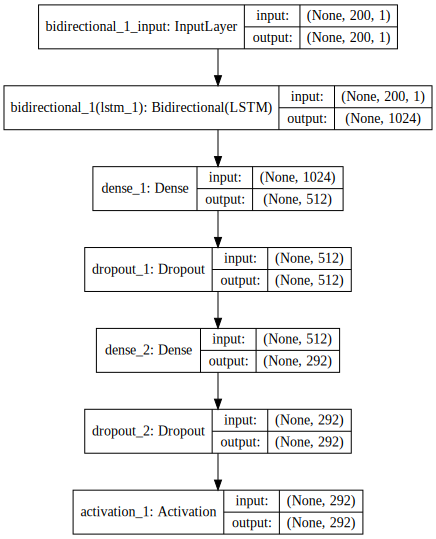

In [7]:
import pydot
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [8]:
history = pd.read_pickle(history_file)

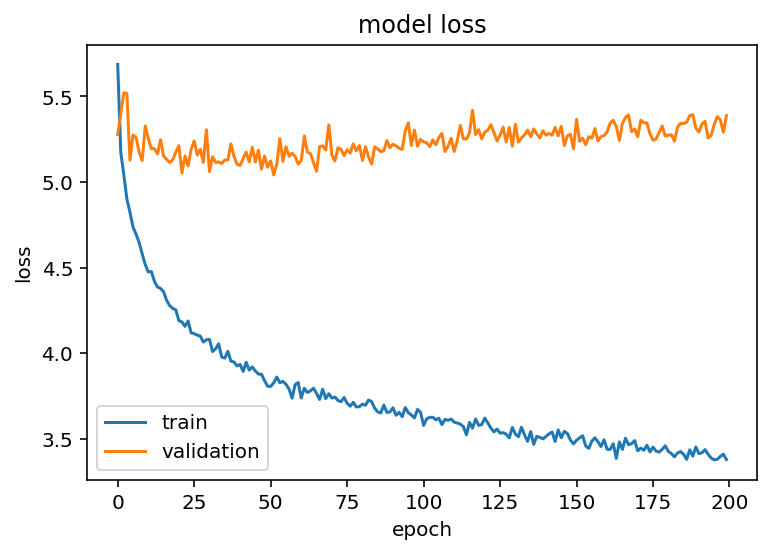

In [9]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

### Analyze created MIDI

In [10]:
import pretty_midi
import matplotlib.pyplot as plt
import librosa.display
import pandas as pd
import IPython.display as ipd

In [11]:
fs = 16000
rate = 16000
start_pitch = 24
end_pitch = 84

In [12]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=10):
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))
    
def analyze_midi(midi_file):
    instrument_dict = {}
    pm = pretty_midi.PrettyMIDI(midi_file)
    plt.figure(figsize=(12, 6))
    plot_piano_roll(pm, start_pitch, end_pitch)
    print("Time Signature Changes: {} Instruments: {}".format(len(pm.time_signature_changes), len(pm.instruments)))
    for instrument_num in range(len(pm.instruments)):
        instrument_dict[instrument_num] = {'Notes': len(pm.instruments[instrument_num].notes), 
                                           'Pitch_Bends':len(pm.instruments[instrument_num].pitch_bends),
                                           'Control_Changes':len(pm.instruments[instrument_num].control_changes)}
    instrument_dict = pd.DataFrame(instrument_dict)
    return instrument_dict, pm

Time Signature Changes: 0 Instruments: 1


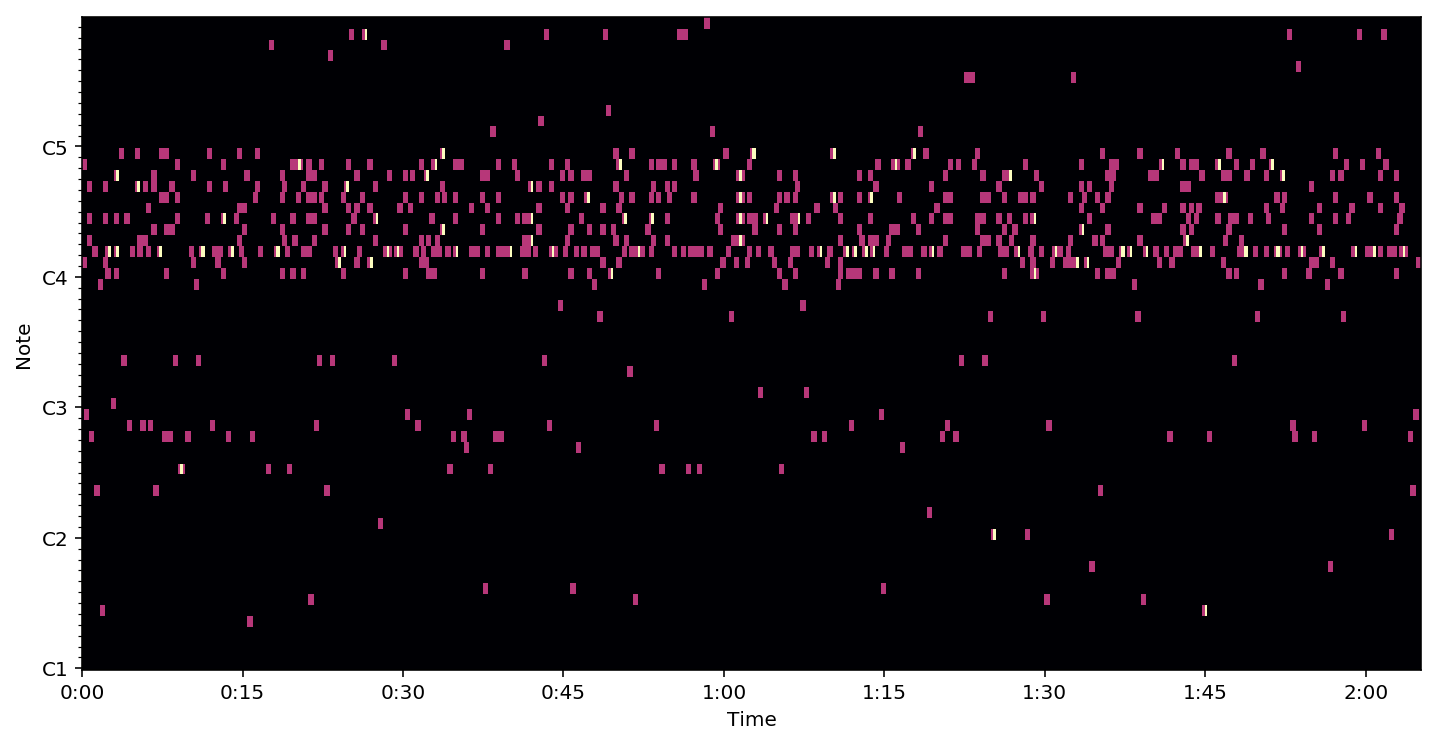

In [13]:
# midi_file = 'output/201803281154-100-lstm_midi.mid'
instrument_dict,pm = analyze_midi(midi_file)
ipd.Audio(pm.synthesize(fs=fs), rate=rate)

### Music21

In [14]:
from music21 import *

env = environment.Environment()
env['musicxmlPath'] = '/usr/bin/musescore'
env['lilypondPath'] = '/usr/bin/lilypond'
env['musescoreDirectPNGPath'] = '/usr/bin/musescore'
env['pdfPath'] = '/usr/bin/lilypond'
env['graphicsPath'] = '/usr/bin/lilypond'

In [15]:
note_stream = stream.Stream()
for note in output_notes:
    note_stream.append(note)
    print(note)
# note_stream.show()

<music21.chord.Chord B- C#>
<music21.note.Note B>
<music21.chord.Chord E- F G#>
<music21.note.Note A>
<music21.chord.Chord D>
<music21.note.Note E>
<music21.note.Note B>
<music21.note.Note F>
<music21.chord.Chord C# F G#>
<music21.chord.Chord C D>
<music21.chord.Chord D>
<music21.note.Note C>
<music21.chord.Chord A C D F>
<music21.chord.Chord A D>
<music21.chord.Chord B>
<music21.note.Note E>
<music21.chord.Chord F>
<music21.note.Note B->
<music21.chord.Chord D>
<music21.note.Note E>
<music21.chord.Chord G# B>
<music21.chord.Chord D E- G#>
<music21.note.Note B->
<music21.chord.Chord E- G#>
<music21.chord.Chord D F#>
<music21.note.Note B->
<music21.chord.Chord E G# A>
<music21.note.Note E>
<music21.chord.Chord D>
<music21.chord.Chord G B D>
<music21.note.Note A>
<music21.chord.Chord B C E G>
<music21.note.Note A>
<music21.chord.Chord E G#>
<music21.note.Note E>
<music21.chord.Chord F G B->
<music21.note.Note F#>
<music21.note.Note F#>
<music21.note.Note F#>
<music21.note.Note A>
<music2